This notebook exists to show the method used to find a 1D CNN that worked for this problem as well as providing an easy place to produce figures for the report. I started off using only one channel for simplicity however the resulting model was not learning enough to get over the problems caused by a skewed database, even when I weighted the classes accordingly. I belived I needed more data or that the model I was using was too big, (too many paramters). So I then looked into adding augmented data into the training set, through mirroring, scaling and shifting as well as reducing the size of the model through its hyperparameters. However this was still not enough. I then thought I might aswell chuck all the data I have at it so combined all 6 channels into one long array and used that. This lead to a model with much better performance!!!!

Most of the hyperparameters used here have been tuned mainly through trial and error.

In [1]:
from database.data import Data
from binary_NN import get_data_CNN, convert_data_to_CNN_format, make_model, train_model, get_split_data

#used to encoded strings to binary 
from sklearn.preprocessing import LabelEncoder

#used for cnn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

#used for class weighting
from sklearn.utils import class_weight

import numpy as np

In [10]:
#defining train split ratio
train_splits = {}
train_splits['train'] = 0.7
train_splits['test'] = 0.3

#creating DATA object
ptb_binary_NN = Data(database = 'ptbdb', denoise_method=None, estimation_method = 'NN', train_splits=train_splits, binary = True, parameterisation = False)

#running preprocessing
ptb_binary_NN.run()

Filtering Database


100%|██████████| 221/221 [00:01<00:00, 179.17it/s]


splitting data into test and train


In [11]:
#just using 1 channel for now (0)
X_train = ptb_binary_NN.split_data[0]['X_train']
y_train = ptb_binary_NN.split_data[0]['y_train']

X_test = ptb_binary_NN.split_data[0]['X_test']
y_test = ptb_binary_NN.split_data[0]['y_test']

In [12]:
#as data set is small we can augment new data types, i.e. shift/mirror

def time_shift(data, shift_max=50):
    shift = np.random.randint(-shift_max, shift_max)
    augmented_data = np.roll(data, shift)
    return augmented_data

def scale_data(data, scale_factor=0.1):
    scale = np.random.uniform(1 - scale_factor, 1 + scale_factor)
    augmented_data = data * scale
    return augmented_data

def augment_data(data):
    augmented_data = []
    for signal in data:
        augmented_data.append(signal)
        augmented_data.append(time_shift(signal))
        augmented_data.append(scale_data(signal))
    return np.array(augmented_data)

In [13]:
X_train_aug = augment_data(X_train)
X_test_aug = augment_data(X_test)

#need to increase the size of the corresponding class data 
y_train_aug = np.tile(y_train, 3)
y_test_aug = np.tile(y_test, 3)

In [22]:
# NN needs encoded labels (1s and 0s) to perform comparissons and calculate probabilities 
# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train_aug)
# y_test_encoded = label_encoder.transform(y_test_aug)

y_train_encoded = [0 if label == 'Unhealthy' else 1 for label in y_train_aug]
y_test_encoded = [0 if label == 'Unhealthy' else 1 for label in y_test_aug]

In [23]:
#CNN needs to know number of features per sample, i.e. 1D
X_train_cnn = np.expand_dims(X_train_aug, axis=-1) 
y_train_cnn = np.expand_dims(y_train_encoded, axis=-1) 
X_test_cnn = np.expand_dims(X_test_aug, axis=-1) 
y_test_cnn = np.expand_dims(y_test_encoded, axis=-1) 

In [24]:
#shows shape of arrays and also can see the skewed classes
print(X_train_cnn.shape)
print(X_test_cnn.shape)
print(y_test_cnn.shape)


print(sum(y_test_cnn))

(411, 60000, 1)
(177, 60000, 1)
(177, 1)
[39]


In [26]:
#finding class weight due to inbalanced class system
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Class Weights:", class_weights_dict)

Class Weights: {0: 0.6413043478260869, 1: 2.269230769230769}


In [10]:
# Define hyperparameters - find out what should be - currently done through trial and error
DEPTH = 1  #number of convolutional layers
FILTERS = 8  #number of filters in each layer
k = 3  # kernel size

# initialise model
cnn = Sequential()

for _ in range(DEPTH):
    cnn.add(Conv1D(filters=FILTERS, kernel_size=k, padding='same', input_shape = (60000, 1)))#each signal is always 60000 samples long
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))
    cnn.add(MaxPooling1D(pool_size=3))  # takes max out of every three, also regularisation
    cnn.add(Dropout(0.5)) #used for regularisation, removes certain percentage of samples each time

cnn.add(Flatten())
cnn.add(Dense(1, activation='sigmoid'))  # use 'softmax' for multi-class classification, 'sigmoid' for binary classification

# build/compile empty model
cnn.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy']) #binary cross entropy for binary classification

#allows you to see the model is built properly
print(cnn.summary())

c:\Users\court\Documents\anaconda\envs\ECG-project\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 60000, 8)       │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60000, 8)       │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 60000, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 20000, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20000, 8)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 160000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       160,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,065 (625.25 KB)

 Trainable params: 160,049 (625.19 KB)

 Non-trainable params: 16 (64.00 B)

None


In [11]:
#fitting the model whilst keeping track of the history for later use

history = cnn.fit(
    X_train_cnn, y_train_cnn,
    epochs=20, #number of repeats 
    batch_size=16,
    validation_data=(X_test_cnn, y_test_cnn),
    class_weight=class_weights_dict #weights training data
)

Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - accuracy: 0.5289 - loss: 12.2222 - val_accuracy: 0.6102 - val_loss: 0.7567
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - accuracy: 0.5063 - loss: 6.8007 - val_accuracy: 0.5650 - val_loss: 1.1272
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.6965 - loss: 4.7524 - val_accuracy: 0.3842 - val_loss: 1.1829
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.7363 - loss: 2.2205 - val_accuracy: 0.4124 - val_loss: 1.6119
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - accuracy: 0.7119 - loss: 1.9677 - val_accuracy: 0.2994 - val_loss: 2.0657
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.7144 - loss: 2.1336 - val_accuracy: 0.2373 - val_loss: 2.9094
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.6987 - loss: 1.6983 - val_accuracy: 0.6949 - val_loss: 0.6725
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.7102 - loss: 1.8394 - val_accuracy: 0

In [12]:
#we can see that this is limited as there is not enough data to overcome the class inblance, accuracy = class inbalnce
loss, accuracy = cnn.evaluate(X_test_cnn, y_test_cnn)
print(f"Validation loss: {loss}")
print(f"Validation accuracy: {accuracy}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6102 - loss: 0.6778
Validation loss: 0.6770959496498108
Validation accuracy: 0.6101694703102112


The above has resulted in a model that has only guessed positive or negative, after considerable fine tuning of parameters to no avail, I believe this to be due to not enough data so below is a repeat with all the data. To allow easy manipulation and repeats I shall use functions.

In [2]:
#maybe limited by amount of data so instead lets try using all the data available, i.e. all 6 channels

#obtaining original data first, takes time to filter so done outside loop
data, labels = get_data_CNN(splits=None, denoise_method = None)


train_splits = {}
train_splits['train'] = 0.7
train_splits['test'] = 0.3

repeats = 5

hist_list = []
model_list = []
data_list = []
labels_list = []
for i in range(repeats):
    #splitting data
    split_data = get_split_data(train_splits, data, labels)

    #converting data to appropriate format and getting class weights
    converted_data, full_labels, class_weights = convert_data_to_CNN_format(split_data, channel_indices = 'all')

    #stating values of hyperparameters for model
    DEPTH = 1
    FILTERS = 16
    k = 3

    #initialising model
    model = make_model(DEPTH, FILTERS, k, print_summary=False)

    #stating values of hyperparameters for training model
    EPOCHS = 20
    BATCH_SIZE = 16

    #should put epochs and stuff outside here
    history, trained_model = train_model(model, converted_data, class_weights, EPOCHS, BATCH_SIZE)

    hist_list.append(history)
    model_list.append(trained_model)
    data_list.append(converted_data)
    labels_list.append(full_labels)

Filtering Database


100%|██████████| 221/221 [00:01<00:00, 118.24it/s]


splitting data into test and train


c:\Users\court\Documents\anaconda\envs\ECG-project\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 23s 404ms/step - accuracy: 0.5443 - loss: 21.8445 - val_accuracy: 0.8012 - val_loss: 0.8439
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 395ms/step - accuracy: 0.8211 - loss: 2.9305 - val_accuracy: 0.8605 - val_loss: 0.3744
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 398ms/step - accuracy: 0.9263 - loss: 0.7563 - val_accuracy: 0.5994 - val_loss: 1.8951
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 399ms/step - accuracy: 0.8839 - loss: 1.0633 - val_accuracy: 0.7864 - val_loss: 0.5314
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 397ms/step - accuracy: 0.9025 - loss: 0.5722 - val_accuracy: 0.8042 - val_loss: 0.4981
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 392ms/step - accuracy: 0.9633 - loss: 0.3024 - val_accuracy: 0.9228 - val_loss: 0.3051
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 393ms/step - accuracy: 0.9791 - loss: 0.0475 - val_accuracy: 0.9496 - val_loss: 0.2596
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 398ms/step - accuracy: 0.9872 - loss: 0.0712 - val_acc

c:\Users\court\Documents\anaconda\envs\ECG-project\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 25s 439ms/step - accuracy: 0.5693 - loss: 16.0962 - val_accuracy: 0.8220 - val_loss: 0.9235
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 38s 381ms/step - accuracy: 0.8108 - loss: 5.8023 - val_accuracy: 0.8576 - val_loss: 1.0988
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 395ms/step - accuracy: 0.8374 - loss: 5.0825 - val_accuracy: 0.8160 - val_loss: 1.2858
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 401ms/step - accuracy: 0.9088 - loss: 1.0572 - val_accuracy: 0.8071 - val_loss: 0.6283
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 399ms/step - accuracy: 0.9071 - loss: 0.7950 - val_accuracy: 0.8398 - val_loss: 0.5197
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 394ms/step - accuracy: 0.9441 - loss: 0.3996 - val_accuracy: 0.7923 - val_loss: 0.6833
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 398ms/step - accuracy: 0.9668 - loss: 0.1974 - val_accuracy: 0.8605 - val_loss: 0.5668
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 396ms/step - accuracy: 0.9199 - loss: 0.6670 - val_acc

c:\Users\court\Documents\anaconda\envs\ECG-project\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 25s 418ms/step - accuracy: 0.5846 - loss: 12.7345 - val_accuracy: 0.7953 - val_loss: 1.3152
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 397ms/step - accuracy: 0.8201 - loss: 8.0873 - val_accuracy: 0.6261 - val_loss: 1.0823
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 406ms/step - accuracy: 0.8197 - loss: 1.3973 - val_accuracy: 0.6825 - val_loss: 1.0817
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 389ms/step - accuracy: 0.9270 - loss: 0.7455 - val_accuracy: 0.8338 - val_loss: 0.5856
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 380ms/step - accuracy: 0.9550 - loss: 0.3115 - val_accuracy: 0.8694 - val_loss: 0.3925
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 389ms/step - accuracy: 0.9986 - loss: 0.0156 - val_accuracy: 0.9407 - val_loss: 0.2593
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 391ms/step - accuracy: 0.9996 - loss: 0.0081 - val_accuracy: 0.9466 - val_loss: 0.2190
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 388ms/step - accuracy: 0.9876 - loss: 0.1059 - val_acc

c:\Users\court\Documents\anaconda\envs\ECG-project\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 22s 397ms/step - accuracy: 0.5289 - loss: 19.0106 - val_accuracy: 0.6469 - val_loss: 4.5864
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 378ms/step - accuracy: 0.7470 - loss: 11.0681 - val_accuracy: 0.8398 - val_loss: 0.6951
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 398ms/step - accuracy: 0.9205 - loss: 0.5526 - val_accuracy: 0.9169 - val_loss: 0.3075
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 387ms/step - accuracy: 0.9026 - loss: 0.8658 - val_accuracy: 0.9050 - val_loss: 0.3862
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 384ms/step - accuracy: 0.9506 - loss: 0.3617 - val_accuracy: 0.8754 - val_loss: 0.6761
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 385ms/step - accuracy: 0.9378 - loss: 0.8002 - val_accuracy: 0.8932 - val_loss: 0.4444
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 385ms/step - accuracy: 0.9389 - loss: 0.4046 - val_accuracy: 0.9466 - val_loss: 0.2884
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 376ms/step - accuracy: 0.8783 - loss: 1.2588 - val_ac

c:\Users\court\Documents\anaconda\envs\ECG-project\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 22s 392ms/step - accuracy: 0.5479 - loss: 21.1555 - val_accuracy: 0.5905 - val_loss: 1.5601
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 383ms/step - accuracy: 0.8009 - loss: 4.0187 - val_accuracy: 0.8220 - val_loss: 1.2032
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 382ms/step - accuracy: 0.8459 - loss: 2.1226 - val_accuracy: 0.7270 - val_loss: 1.4507
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 394ms/step - accuracy: 0.9043 - loss: 0.9736 - val_accuracy: 0.7834 - val_loss: 1.0861
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 25s 511ms/step - accuracy: 0.9376 - loss: 0.4923 - val_accuracy: 0.9050 - val_loss: 0.5165
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 381ms/step - accuracy: 0.9249 - loss: 0.4122 - val_accuracy: 0.9139 - val_loss: 0.3938
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 391ms/step - accuracy: 0.8169 - loss: 2.9751 - val_accuracy: 0.8872 - val_loss: 0.4322
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 378ms/step - accuracy: 0.9562 - loss: 0.3354 - val_acc

In [7]:
loss, accuracy = model_list[0].evaluate(data_list[0]['X_test'], data_list[0]['y_test'])#continue this
print(f"Validation loss: {loss}")
print(f"Validation accuracy: {accuracy}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.8754 - loss: 0.3639
Validation loss: 0.30370086431503296
Validation accuracy: 0.9109792113304138


## Metrics for table

In [3]:
from sklearn.metrics import classification_report
from models.scoring_metrics import get_all_metrics
from models.SVM.binary_classification import manual_y_predict

performance_metrics = []
for i in range(repeats):
    X_test = data_list[i]['X_test']
    y_test = data_list[i]['y_test']


    y_pred = model_list[i].predict(X_test)

    threshold = 1-np.sum(y_test)/len(y_test)

    #threshold = 0.3

    y_pred_classes = manual_y_predict(y_pred, threshold)
    
    y_pred_encoded = (y_pred > threshold).astype(int)


    performance_metrics.append(get_all_metrics(labels_list[i], y_pred_classes))
    

    print(classification_report(y_test, y_pred_encoded))

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 213ms/step
66
0
7
66
0
7
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       264
           1       1.00      0.90      0.95        73

    accuracy                           0.98       337
   macro avg       0.99      0.95      0.97       337
weighted avg       0.98      0.98      0.98       337

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step
57
0
16
57
0
16
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       264
           1       1.00      0.78      0.88        73

    accuracy                           0.95       337
   macro avg       0.97      0.89      0.92       337
weighted avg       0.96      0.95      0.95       337

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step
60
0
13
60
0
13
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       264
           1       1.00      0.82      0.90        73

    accuracy 

In [5]:
# Initialize an empty dictionary to store averaged scores
averaged_scores = {}

# Iterate through each channel in the dictionaries
for metric in performance_metrics[0].keys():
    # Calculate the average of the current metric
    values = [score[metric] for score in performance_metrics]
    mean_value = np.mean(values)
    std_value = np.std(values)
    averaged_scores[metric] = (mean_value, std_value)

# Print the averaged scores with 2 decimal places
for metric, (mean_value, std_value) in averaged_scores.items():
    print(f'  {metric}: {mean_value:.2f} ± {std_value:.2f}')
print()

  bal acc: 0.92 ± 0.03
  accuracy: 0.96 ± 0.01
  f1: 0.91 ± 0.03
  obj score: 0.91 ± 0.03
  recall: 0.85 ± 0.06
  precision: 0.98 ± 0.03



In [6]:
#need to make all epoch arrays same length so averages can be calculated
accuracy_list = []
val_accuracy_list = []
loss_list = []
val_loss_list = []

for i in range(repeats):

    accuracy_list.append(hist_list[i].history['accuracy'])
    val_accuracy_list.append(hist_list[i].history['val_accuracy'])
    loss_list.append(hist_list[i].history['loss'])
    val_loss_list.append(hist_list[i].history['val_loss'])

In [16]:
def extend_arrays_to_max_length(arrays):
    # Determine the maximum length of the arrays
    max_length = max(len(arr) for arr in arrays)
    
    # Convert all arrays to numpy arrays for easier manipulation
    arrays = [np.array(arr) for arr in arrays]
    
    # Create a new list to hold the extended arrays
    extended_arrays = []
    
    for arr in arrays:
        # Calculate the length of the current array
        current_length = len(arr)
        
        if current_length < max_length:
            # If the current array is shorter than the maximum length, extend it
            # Create a placeholder for the new elements
            new_elements = []
            
            for i in range(current_length, max_length):
                # Calculate the average for this position from other arrays
                # Filter out arrays that are shorter than the current index
                valid_values = [other_arr[i] for other_arr in arrays if len(other_arr) > i]
                # Compute the average
                avg_value = np.mean(valid_values)
                new_elements.append(avg_value)
            
            # Append the new elements to the original array
            extended_arr = np.concatenate([arr, new_elements])
        else:
            # If the current array is already the maximum length, keep it as is
            extended_arr = arr
        
        # Add the extended array to the list
        extended_arrays.append(extended_arr)
    
    return extended_arrays

In [30]:
history_dict = {}

history_dict['loss'] = extend_arrays_to_max_length(loss_list)
history_dict['val_loss'] = extend_arrays_to_max_length(val_loss_list)
history_dict['val_acc'] = extend_arrays_to_max_length(val_accuracy_list)
history_dict['acc'] = extend_arrays_to_max_length(accuracy_list)


## Model Performance

[]

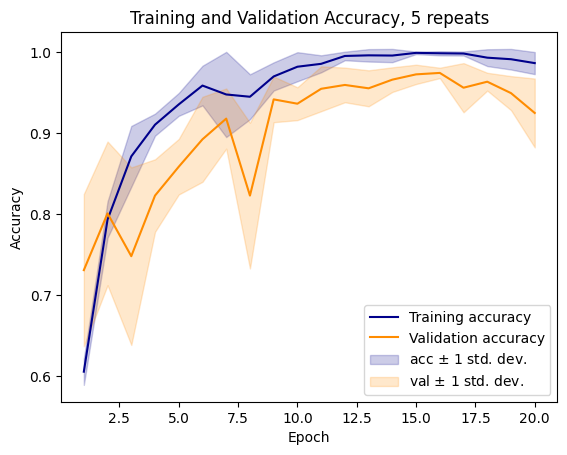

In [35]:
import matplotlib.pyplot as plt

full_acc_list = []
full_val_list = []
for i in range(repeats):
    full_acc_list.append(history_dict['acc'][i])
    full_val_list.append(history_dict['val_acc'][i])


average_acc = np.mean(full_acc_list, axis = 0)
average_val = np.mean(full_val_list, axis=0)
std_acc = np.std(full_acc_list, axis=0)
std_val = np.std(full_val_list, axis=0)


epochs = range(1, len(average_acc) + 1)

plt.plot(epochs, average_acc, color='darkblue', label='Training accuracy')
plt.plot(epochs, average_val, color='darkorange', label='Validation accuracy')
plt.fill_between(epochs, average_acc - std_acc, average_acc + std_acc, color='darkblue', alpha=.2, label=r'acc $\pm$ 1 std. dev.')
plt.fill_between(epochs, average_val - std_val, average_val + std_val, color='darkorange', alpha=.2, label=r'val $\pm$ 1 std. dev.')
plt.title(f'Training and Validation Accuracy, {repeats} repeats')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig('figures\\train_vs_val_acc.png', bbox_inches='tight')
plt.plot()

[]

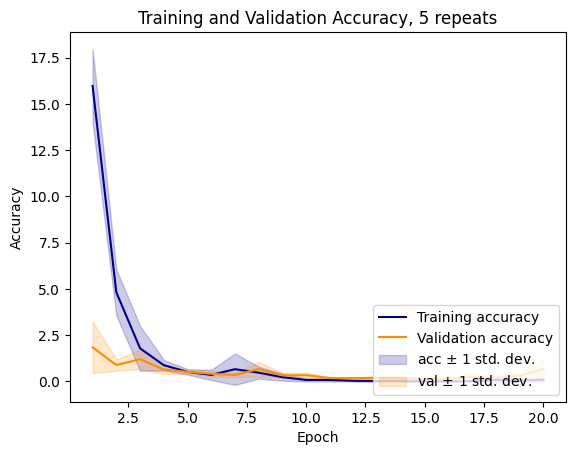

In [36]:
#same for loss

full_loss_list = []
full_val_loss_list = []
for i in range(repeats):
    full_loss_list.append(history_dict['loss'][i])
    full_val_loss_list.append(history_dict['val_loss'][i])

average_loss = np.mean(full_loss_list, axis = 0)
average_val_loss = np.mean(full_val_loss_list, axis=0)
std_loss = np.std(full_loss_list, axis=0)
std_val_loss = np.std(full_val_loss_list, axis=0)


plt.plot(epochs, average_loss, color='darkblue', label='Training accuracy')
plt.plot(epochs, average_val_loss, color='darkorange', label='Validation accuracy')
plt.fill_between(epochs, average_loss - std_loss, average_loss + std_loss, color='darkblue', alpha=.2, label=r'acc $\pm$ 1 std. dev.')
plt.fill_between(epochs, average_val_loss - std_val_loss, average_val_loss + std_val_loss, color='darkorange', alpha=.2, label=r'val $\pm$ 1 std. dev.')
plt.title(f'Training and Validation Accuracy, {repeats} repeats')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.savefig('figures\\train_vs_val_loss.png', bbox_inches='tight')
plt.plot()

## ROC curve

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step


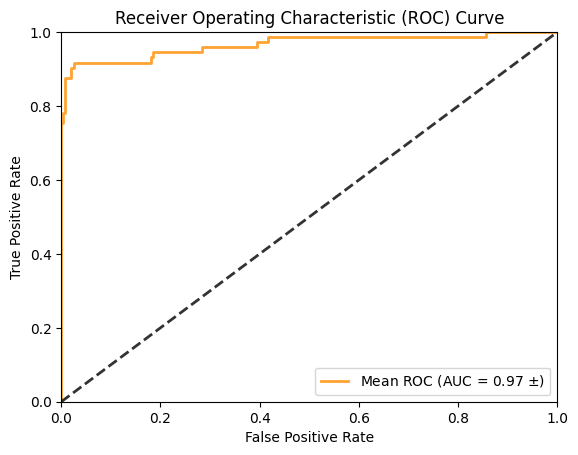

In [63]:
y_test = data_list[4]['y_test']
X_test = data_list[4]['X_test']


y_pred = model_list[4].predict(X_test)

fpr, tpr, _ = roc_curve(y_test, y_pred)

roc_auc = auc(fpr, tpr)

# plotting average ROC curve for all iterations
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=r'Mean ROC (AUC = %0.2f $\pm$)' % (roc_auc), lw=2, alpha=.8)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', alpha=.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [57]:
from sklearn.metrics import roc_curve, auc


mean_fpr = np.linspace(0, 1, 100)#roc_curve produces different length arrays so need to standardise

auc_list = []
interp_tpr_list = []
for i in range(repeats):
    y_test = data_list[i]['y_test']
    X_test = data_list[i]['X_test']

    y_pred = model_list[i].predict(X_test)
    
    fpr, tpr, _ = roc_curve(y_test, y_pred)

    auc_list.append(auc(fpr, tpr))

    #need to interpolate everything so they are the desired length
    interp_tpr_list.append(np.interp(mean_fpr, fpr, tpr))



mean_tpr = np.mean(interp_tpr_list, axis = 0)
mean_auc = np.mean(auc_list, axis=0)

std_tpr = np.std(interp_tpr_list, axis=0)
std_auc = np.std(auc_list, axis=0)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step


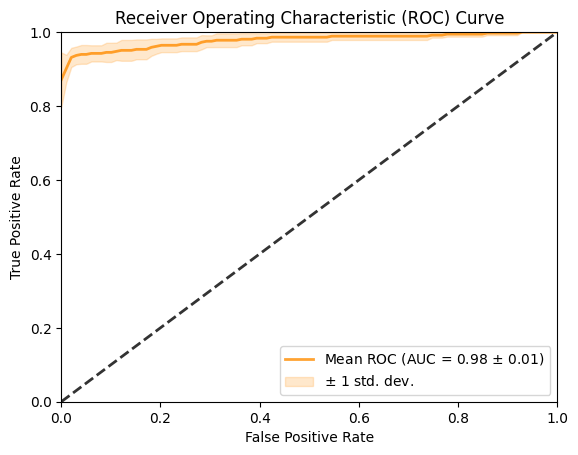

In [58]:
# plotting average ROC curve for all iterations
plt.figure()
plt.plot(mean_fpr, mean_tpr, color='darkorange', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)
plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='darkorange', alpha=.2, label=r'$\pm$ 1 std. dev.')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', alpha=.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('figures\\ROC_CNN.png', bbox_inches='tight')
plt.show()

## Confusion Matrix

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step


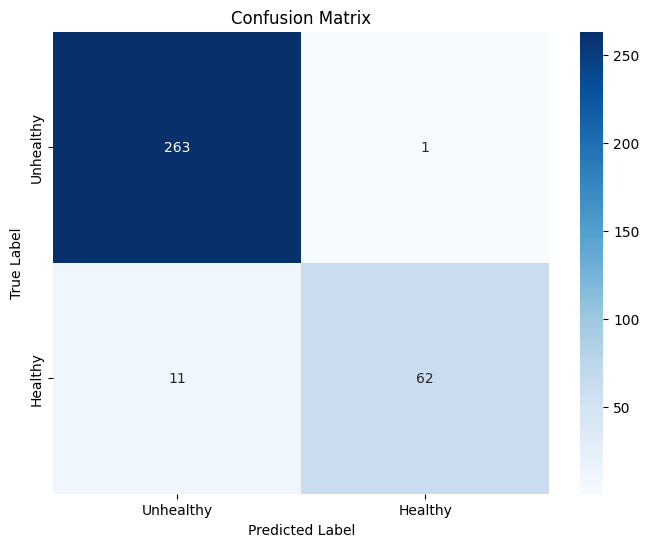

In [71]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


# need to average a load of confusion matrices
cm_sum = np.zeros((2, 2), dtype=int)  # 2*2 for binary classification
cm_list = []
for i in range(repeats):
    y_test = data_list[i]['y_test']
    X_test = data_list[i]['X_test']

    y_pred = model_list[i].predict(X_test)

    threshold = 1-np.sum(y_test)/len(y_test)

    y_pred_encoded = (y_pred > threshold).astype(int)

    cm = confusion_matrix(y_test, y_pred_encoded)
    cm_sum += cm

    cm_list.append(cm)


# average total cm 
cm_avg = cm_sum / repeats

# Calculate the variance and standard deviation
cm_variance = np.zeros((2, 2), dtype=float)
for cm in cm_list:
    cm_variance += (cm - cm_avg) ** 2

cm_variance /= repeats
cm_std_dev = np.sqrt(cm_variance)

# rounding to integers
cm_avg_rounded = np.round(cm_avg).astype(int)
cm_std_dev_rounded = np.round(cm_std_dev).astype(int)


import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm_avg_rounded, annot=True, fmt='d', cmap='Blues', xticklabels=['Unhealthy', 'Healthy'], yticklabels=['Unhealthy', 'Healthy'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('figures\\confusion_matrix_CNN.png', bbox_inches='tight')
plt.show()

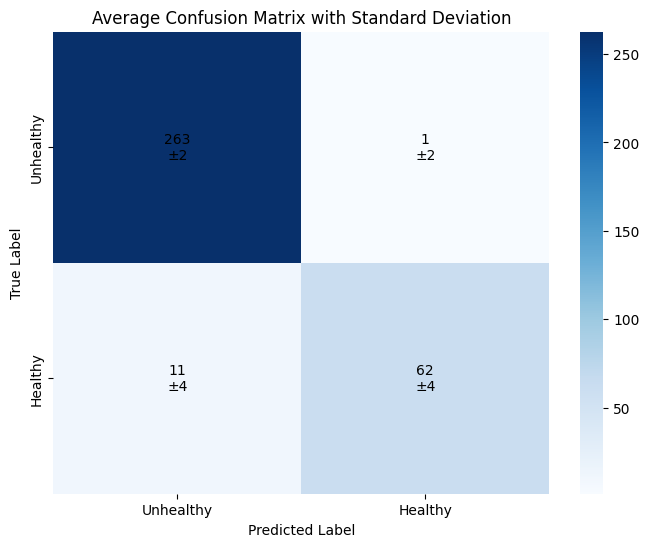

In [72]:
# Create the heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(cm_avg, annot=False, cmap='Blues', xticklabels=['Unhealthy', 'Healthy'], yticklabels=['Unhealthy', 'Healthy'])

# Add annotations for both average values and standard deviation
for i in range(cm_avg.shape[0]):
    for j in range(cm_avg.shape[1]):
        plt.text(j + 0.5, i + 0.5, f'{cm_avg_rounded[i, j]}\n±{cm_std_dev_rounded[i, j]}', 
                 ha='center', va='center', color='black')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Average Confusion Matrix with Standard Deviation')
plt.savefig('figures/confusion_matrix_CNN.png', bbox_inches='tight')
plt.show()

## How results vary with different train test splits

In [73]:
#obtaining original data first, takes time to filter so done outside loop
data, labels = get_data_CNN(splits=None, denoise_method = None)

#listing different train test splits
train_splits_list = []

train_splits2 = {}
train_splits2['train'] = 0.8
train_splits2['test'] = 0.2
train_splits_list.append(train_splits2)

train_splits1 = {}
train_splits1['train'] = 0.7
train_splits1['test'] = 0.3
train_splits_list.append(train_splits1)

train_splits3 = {}
train_splits3['train'] = 0.6
train_splits3['test'] = 0.4
train_splits_list.append(train_splits3)

train_splits4 = {}
train_splits4['train'] = 0.5
train_splits4['test'] = 0.5
train_splits_list.append(train_splits4)

train_splits5 = {}
train_splits5['train'] = 0.4
train_splits5['test'] = 0.6
train_splits_list.append(train_splits5)

train_splits6 = {}
train_splits6['train'] = 0.3
train_splits6['test'] = 0.7
train_splits_list.append(train_splits6)


hist_list = []
model_list = []
data_list = []
labels_list = []
for i in range(0, len(train_splits_list)):
    #splitting data
    split_data = get_split_data(train_splits_list[i], data, labels)

    #converting data to appropriate format and getting class weights
    converted_data, full_labels, class_weights = convert_data_to_CNN_format(split_data, channel_indices = 'all')

    #stating values of hyperparameters for model
    DEPTH = 1
    FILTERS = 16
    k = 3

    #initialising model
    model = make_model(DEPTH, FILTERS, k, print_summary=False)

    #stating values of hyperparameters for training model
    EPOCHS = 20
    BATCH_SIZE = 16

    #should put epochs and stuff outside here
    history, trained_model = train_model(model, converted_data, class_weights, EPOCHS, BATCH_SIZE)

    hist_list.append(history)
    model_list.append(trained_model)
    data_list.append(converted_data)
    labels_list.append(full_labels)

Filtering Database


100%|██████████| 221/221 [00:02<00:00, 80.34it/s] 


splitting data into test and train


c:\Users\court\Documents\anaconda\envs\ECG-project\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 31s 429ms/step - accuracy: 0.5659 - loss: 25.9120 - val_accuracy: 0.8899 - val_loss: 0.5425
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - accuracy: 0.8707 - loss: 1.5601 - val_accuracy: 0.5727 - val_loss: 3.8302
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 360ms/step - accuracy: 0.8500 - loss: 2.5814 - val_accuracy: 0.5859 - val_loss: 2.5297
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.8521 - loss: 1.6452 - val_accuracy: 0.9075 - val_loss: 0.4202
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 351ms/step - accuracy: 0.9288 - loss: 0.8235 - val_accuracy: 0.8326 - val_loss: 0.8548
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 358ms/step - accuracy: 0.9512 - loss: 0.3927 - val_accuracy: 0.8282 - val_loss: 0.5530
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 356ms/step - accuracy: 0.9371 - loss: 0.3632 - val_accuracy: 0.8943 - val_loss: 0.4872
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 357ms/step - accuracy: 0.9657 - loss: 0.1559 - val_acc

c:\Users\court\Documents\anaconda\envs\ECG-project\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 23s 396ms/step - accuracy: 0.6220 - loss: 7.1861 - val_accuracy: 0.7270 - val_loss: 1.4056
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 383ms/step - accuracy: 0.7983 - loss: 5.6835 - val_accuracy: 0.6409 - val_loss: 1.0050
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 373ms/step - accuracy: 0.9135 - loss: 1.1602 - val_accuracy: 0.7240 - val_loss: 0.9444
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 378ms/step - accuracy: 0.9177 - loss: 0.6385 - val_accuracy: 0.8724 - val_loss: 0.5834
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 372ms/step - accuracy: 0.9040 - loss: 1.3697 - val_accuracy: 0.9050 - val_loss: 0.3810
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 365ms/step - accuracy: 0.9730 - loss: 0.1850 - val_accuracy: 0.8042 - val_loss: 0.5067
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 372ms/step - accuracy: 0.9851 - loss: 0.1001 - val_accuracy: 0.8576 - val_loss: 0.4661
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 373ms/step - accuracy: 0.9724 - loss: 0.1257 - val_accu

c:\Users\court\Documents\anaconda\envs\ECG-project\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 416ms/step - accuracy: 0.6563 - loss: 17.6622 - val_accuracy: 0.5200 - val_loss: 1.5399
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 392ms/step - accuracy: 0.7403 - loss: 4.1578 - val_accuracy: 0.6600 - val_loss: 1.0563
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 380ms/step - accuracy: 0.8652 - loss: 1.6973 - val_accuracy: 0.8378 - val_loss: 0.7574
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 389ms/step - accuracy: 0.9181 - loss: 1.9331 - val_accuracy: 0.7978 - val_loss: 0.5189
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 17s 398ms/step - accuracy: 0.9445 - loss: 0.4190 - val_accuracy: 0.8711 - val_loss: 0.3971
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 388ms/step - accuracy: 0.9870 - loss: 0.1547 - val_accuracy: 0.8444 - val_loss: 0.4141
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 389ms/step - accuracy: 0.9709 - loss: 0.0999 - val_accuracy: 0.7867 - val_loss: 0.6064
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 390ms/step - accuracy: 0.9859 - loss: 0.0626 - val_acc

c:\Users\court\Documents\anaconda\envs\ECG-project\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 19s 467ms/step - accuracy: 0.5551 - loss: 24.5184 - val_accuracy: 0.4482 - val_loss: 6.0333
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 441ms/step - accuracy: 0.7068 - loss: 14.5281 - val_accuracy: 0.8554 - val_loss: 0.4825
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 443ms/step - accuracy: 0.8542 - loss: 2.6219 - val_accuracy: 0.8696 - val_loss: 0.5466
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 440ms/step - accuracy: 0.8992 - loss: 1.5403 - val_accuracy: 0.8393 - val_loss: 0.4670
Epoch 5/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 431ms/step - accuracy: 0.9229 - loss: 0.5298 - val_accuracy: 0.7661 - val_loss: 0.6887
Epoch 6/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 440ms/step - accuracy: 0.9254 - loss: 0.7764 - val_accuracy: 0.8696 - val_loss: 0.6426
Epoch 7/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 16s 442ms/step - accuracy: 0.9259 - loss: 0.3674 - val_accuracy: 0.8107 - val_loss: 0.5747
Epoch 8/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 431ms/step - accuracy: 0.9507 - loss: 0.2726 - val_ac

c:\Users\court\Documents\anaconda\envs\ECG-project\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 17s 486ms/step - accuracy: 0.6014 - loss: 17.1096 - val_accuracy: 0.6202 - val_loss: 3.4524
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 451ms/step - accuracy: 0.7370 - loss: 5.5736 - val_accuracy: 0.6469 - val_loss: 1.3212
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 472ms/step - accuracy: 0.7661 - loss: 4.4994 - val_accuracy: 0.5326 - val_loss: 2.2118
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 448ms/step - accuracy: 0.8257 - loss: 3.1262 - val_accuracy: 0.8605 - val_loss: 0.4917
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 447ms/step - accuracy: 0.9179 - loss: 1.1964 - val_accuracy: 0.8798 - val_loss: 0.4158
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 451ms/step - accuracy: 0.8964 - loss: 1.3100 - val_accuracy: 0.6721 - val_loss: 2.0737
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 451ms/step - accuracy: 0.8960 - loss: 0.7326 - val_accuracy: 0.4807 - val_loss: 2.9335
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 441ms/step - accuracy: 0.8216 - loss: 3.5970 - val_acc

c:\Users\court\Documents\anaconda\envs\ECG-project\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 488ms/step - accuracy: 0.5389 - loss: 22.7748 - val_accuracy: 0.7878 - val_loss: 0.5940
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 464ms/step - accuracy: 0.8020 - loss: 5.2540 - val_accuracy: 0.8249 - val_loss: 0.5467
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 446ms/step - accuracy: 0.7865 - loss: 4.1361 - val_accuracy: 0.5267 - val_loss: 3.0763
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 463ms/step - accuracy: 0.8569 - loss: 3.5168 - val_accuracy: 0.7493 - val_loss: 0.6295
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 476ms/step - accuracy: 0.9331 - loss: 0.5363 - val_accuracy: 0.8220 - val_loss: 0.5347
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 442ms/step - accuracy: 0.8470 - loss: 1.4675 - val_accuracy: 0.5386 - val_loss: 2.3993
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 458ms/step - accuracy: 0.9103 - loss: 1.2339 - val_accuracy: 0.8680 - val_loss: 0.5004
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 461ms/step - accuracy: 0.9746 - loss: 0.1812 - val_acc

In [80]:
losses = []
accuracies = []

for i in range(len(train_splits_list)):
    X_test = data_list[i]['X_test']
    y_test = data_list[i]['y_test']

    loss, accuracy = model_list[i].evaluate(X_test, y_test, verbose=0)
    losses.append(loss)
    accuracies.append(accuracy)

x_ticks_list = []
for split in train_splits_list:
    x_ticks_list.append(split['train'] * 100)

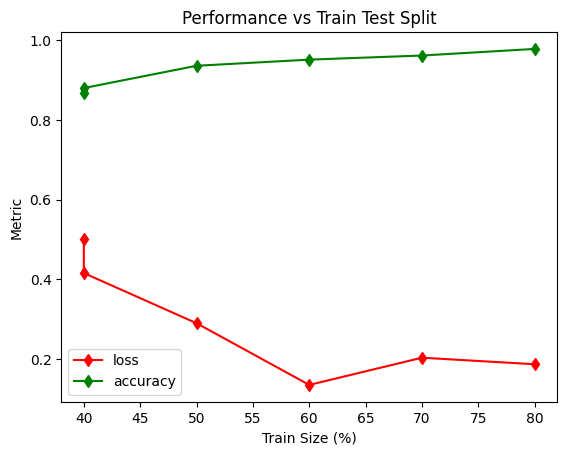

In [84]:
fig, axes = plt.subplots()

axes.plot(x_ticks_list, losses, color='red', marker = 'd', label='loss')
axes.plot(x_ticks_list, accuracies, color='green', marker='d', label = 'accuracy')
axes.set_xlabel('Train Size (%)')
axes.set_ylabel('Metric')
axes.set_title('Performance vs Train Test Split')
axes.legend()
plt.savefig('figures/CNN_train_test_split.png', bbox_inches='tight')
plt.show()

## Results vary using different filters

In [85]:

different_filter_names = ['butterworth', 'DWT', None]

train_splits = {}
train_splits['train'] = 0.7
train_splits['test'] = 0.3


hist_list = []
model_list = []
data_list = []
labels_list = []

for i in range(0, len(different_filter_names)):
    #obtaining split data within data gen as has to run anyway
    split_data = get_data_CNN(splits=train_splits, denoise_method = different_filter_names[i])

    #converting data to appropriate format and getting class weights
    converted_data, full_labels, class_weights = convert_data_to_CNN_format(split_data, channel_indices = 'all')

    #stating values of hyperparameters for model
    DEPTH = 1
    FILTERS = 16
    k = 3

    #initialising model
    model = make_model(DEPTH, FILTERS, k, print_summary=False)

    #stating values of hyperparameters for training model
    EPOCHS = 20
    BATCH_SIZE = 16

    #should put epochs and stuff outside here
    history, trained_model = train_model(model, converted_data, class_weights, EPOCHS, BATCH_SIZE)

    hist_list.append(history)
    model_list.append(trained_model)
    data_list.append(converted_data)
    labels_list.append(full_labels)

Filtering Database


100%|██████████| 221/221 [00:02<00:00, 75.30it/s] 


denoising signals through butterworth filter method
normalising signals
splitting data into test and train


c:\Users\court\Documents\anaconda\envs\ECG-project\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 23s 394ms/step - accuracy: 0.5321 - loss: 15.5275 - val_accuracy: 0.2196 - val_loss: 1.9823
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 381ms/step - accuracy: 0.6319 - loss: 3.8385 - val_accuracy: 0.6499 - val_loss: 0.7394
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 374ms/step - accuracy: 0.7332 - loss: 5.2534 - val_accuracy: 0.3056 - val_loss: 1.2622
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 369ms/step - accuracy: 0.7084 - loss: 2.2316 - val_accuracy: 0.2196 - val_loss: 1.3111
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 0.8567 - loss: 0.6420 - val_accuracy: 0.8190 - val_loss: 0.5048
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 375ms/step - accuracy: 0.9459 - loss: 0.1460 - val_accuracy: 0.9050 - val_loss: 0.5800
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 382ms/step - accuracy: 0.9282 - loss: 0.2237 - val_accuracy: 0.9288 - val_loss: 0.5970
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 400ms/step - accuracy: 0.9627 - loss: 0.1254 - val_acc

100%|██████████| 221/221 [00:03<00:00, 69.90it/s]


denoising signals through Discrete Wavelet Transform
normalising signals
splitting data into test and train


c:\Users\court\Documents\anaconda\envs\ECG-project\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 24s 395ms/step - accuracy: 0.5457 - loss: 17.6035 - val_accuracy: 0.4688 - val_loss: 0.6942
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 371ms/step - accuracy: 0.6578 - loss: 3.6356 - val_accuracy: 0.8694 - val_loss: 0.5732
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 390ms/step - accuracy: 0.8197 - loss: 2.5891 - val_accuracy: 0.7151 - val_loss: 0.6378
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 375ms/step - accuracy: 0.9651 - loss: 0.1126 - val_accuracy: 0.8783 - val_loss: 0.5363
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 376ms/step - accuracy: 0.9292 - loss: 0.3499 - val_accuracy: 0.3412 - val_loss: 1.7001
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 379ms/step - accuracy: 0.9412 - loss: 0.2883 - val_accuracy: 0.8516 - val_loss: 0.4395
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 376ms/step - accuracy: 0.9995 - loss: 0.0264 - val_accuracy: 0.9169 - val_loss: 0.3758
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 368ms/step - accuracy: 1.0000 - loss: 0.0183 - val_acc

100%|██████████| 221/221 [00:01<00:00, 178.29it/s]


splitting data into test and train


c:\Users\court\Documents\anaconda\envs\ECG-project\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 23s 410ms/step - accuracy: 0.5873 - loss: 19.1786 - val_accuracy: 0.7864 - val_loss: 0.7688
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 391ms/step - accuracy: 0.7361 - loss: 3.8866 - val_accuracy: 0.6617 - val_loss: 1.7415
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 390ms/step - accuracy: 0.8624 - loss: 4.4042 - val_accuracy: 0.7596 - val_loss: 0.7538
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 388ms/step - accuracy: 0.9258 - loss: 0.4956 - val_accuracy: 0.9169 - val_loss: 0.3123
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 378ms/step - accuracy: 0.9355 - loss: 0.4567 - val_accuracy: 0.7478 - val_loss: 1.2268
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 385ms/step - accuracy: 0.9687 - loss: 0.2223 - val_accuracy: 0.7953 - val_loss: 0.7092
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 389ms/step - accuracy: 0.9410 - loss: 0.4846 - val_accuracy: 0.9080 - val_loss: 0.5643
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 385ms/step - accuracy: 0.9813 - loss: 0.1357 - val_acc

In [86]:
losses = []
accuracies = []

for i in range(len(different_filter_names)):
    X_test = data_list[i]['X_test']
    y_test = data_list[i]['y_test']

    loss, accuracy = model_list[i].evaluate(X_test, y_test, verbose=0)
    losses.append(loss)
    accuracies.append(accuracy)

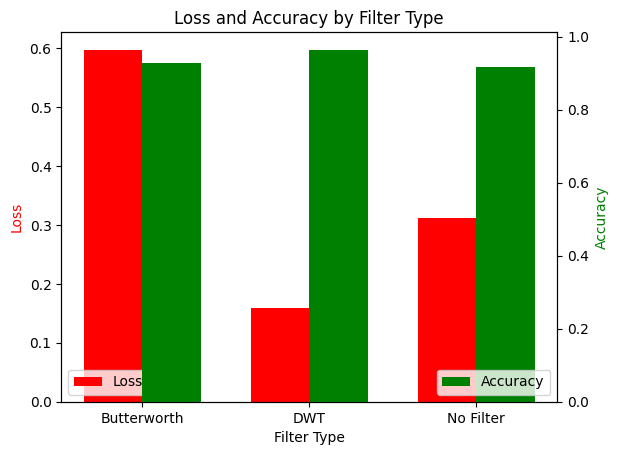

In [92]:
fig, ax1 = plt.subplots()

filter_names = ['Butterworth', 'DWT', 'No Filter']

# Define bar width
bar_width = 0.35

# Define positions for the bars
index = np.arange(len(filter_names))

# Plotting loss bars
loss_bars = ax1.bar(index, losses, bar_width, label='Loss', color='red')

# Set axis labels and title
ax1.set_xlabel('Filter Type')
ax1.set_ylabel('Loss', color='red')
ax1.set_title('Loss and Accuracy by Filter Type')
ax1.set_xticks(index + bar_width/2)
ax1.set_xticklabels(filter_names)

# Create second y-axis to plot accuracy
ax2 = ax1.twinx()
accuracy_bars = ax2.bar(index + bar_width, accuracies, bar_width, label='Accuracy', color='green')

# Set accuracy axis label
ax2.set_ylabel('Accuracy', color='green')

# Add legends
ax1.legend(loc='lower left')
ax2.legend(loc='lower right')


plt.savefig('figures/loss_accuracy_vs_filter_type.png', bbox_inches='tight')
# Show plot
plt.show()
